<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/notebooks/2021_0606Mizuno_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 水野 (2016) 日本語の連想頻度表

- date: 2020-0602 modified
- author: shin asakawa <sakawa@ieee.org>
- note: 水野先生のデータベース，漢字，かな，カナの表記 3 種類が別々の excel files である。
- title: 連想語頻度表―3モーラの漢字・ひらがな・カタカナ表記語
- author: 水野 りか, 清河 幸子, 川上 正浩, 柳谷 啓子
- year: 2011
- publisher: ナカニシヤ出版
- amazon: https://www.amazon.co.jp/dp/4779505623/


In [1]:
# The location where Excel files are
#水野エクセルファイルの場所を指定
mizuno_base = '.'

In [ ]:
import sys
import os
import numpy as np

import pandas as pd
import termcolor

import matplotlib.pyplot as plt
!pip install japanize_matplotlib
import japanize_matplotlib

#from scipy import stats  #スピアマンブラウンの順位相関係数のライブラリの読み込み
#import ja_util

In [ ]:
#このセルは Colab 用のコード
##形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
##reference: https://qiita.com/jun40vn/items/78e33e29dce3d50c2df1
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n
!pip install mecab-python3

# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

#訓練済 word2vec ファイルの取得
##!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1B9HGhLZOja4Xku5c_d-kMhCXn1LBZgDb' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1B9HGhLZOja4Xku5c_d-kMhCXn1LBZgDb" -O 2021_05jawiki_hid128_win10_neg10_cbow.bin.gz && rm -rf /tmp/cookies.txt
##!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OWmFOVRC6amCxsomcRwdA6ILAA5s4y4M' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OWmFOVRC6amCxsomcRwdA6ILAA5s4y4M" -O 2021_05jawiki_hid128_win10_neg10_sgns.bin.gz && rm -rf /tmp/cookies.txt
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JTkU5SUBU2GkURCYeHkAWYs_Zlbqob0s' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JTkU5SUBU2GkURCYeHkAWYs_Zlbqob0s" -O 2021_05jawiki_hid200_win20_neg20_cbow.bin.gz && rm -rf /tmp/cookies.txt
##!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VPL2Mr9JgWHik9HjRmcADoxXIdrQ3ds7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VPL2Mr9JgWHik9HjRmcADoxXIdrQ3ds7" -O 2021_05jawiki_hid200_win20_neg20_sgns.bin.gz && rm -rf /tmp/cookies.txt
##!wget http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2021_05jawiki_hid128_win20_neg20_cbow.bin.gz

In [5]:
#word2vec データのため gensim を使う
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# word2vec データの読み込み
w2v_base = '.'
w2v_file = '2021_05jawiki_hid200_win20_neg20_cbow.bin.gz'
# word2vec データの読み込み
asakawa_w2v_file = os.path.join(w2v_base, w2v_file)
asakawa_w2v = KeyedVectors.load_word2vec_format(asakawa_w2v_file, 
                                                encoding='utf-8', 
                                                unicode_errors='replace',
                                                binary=True) 
w2v = asakawa_w2v

In [ ]:
from google.colab import files
uploaded = files.upload()  # 水野エクセル 3 files (kanji, katakana, hiragana) をを指定してアップロードする

In [7]:
#3つのファイルを読み，各ファイルに存在するシート名を印字
print('購入した書籍についていたエクセルファイルのうち `kanji.xls` は行末に不要な空行が付いていた。その空行を削除したファイルが `kanji2.xls` である')
[kanji, katakana, hiragana] = [pd.ExcelFile(os.path.join(mizuno_base, d + '.xls')) for d in ['kanji2', 'katakana', 'hiragana']]
print(kanji.sheet_names)
print(hiragana.sheet_names)
print(katakana.sheet_names)

#上の通り，各ファイルの最初の 3 シートはまとめである。
# 従って 4 シート目以降をを取り出す (sheet_names[3:])
#加えて，各シートの最後の一行は合計であるので，読み込まない (sheet_name=w)[w][:-1])
Kanji = {w:list(kanji.parse(sheet_name=w)[w][:-1]) for w in kanji.sheet_names[3:]}
Kata = {w:list(katakana.parse(sheet_name=w)[w][:-1]) for w in katakana.sheet_names[3:]}
Hira = {w:list(hiragana.parse(sheet_name=w)[w][:-1]) for w in hiragana.sheet_names[3:]}

購入した書籍についていたエクセルファイルのうち `kanji.xls` は行末に不要な空行が付いていた。その空行を削除したファイルが `kanji2.xls` である
['漢字まとめ', '漢字まとめ_複数表記列挙', '連想強度範囲内抽出', '赤字', '悪魔', '育児', '田舎', '移民', '映画', '英語', '汚染', '親子', '絵画', '会議', '介護', '価格', '科学', '火災', '家族', '活字', '家庭', '画面', '看護', '管理', '記憶', '気温', '機械', '危険', '犠牲', '季節', '着物', '議論', '勤務', '空気', '苦労', '検査', '権利', '講義', '国語', '個人', '古典', '言葉', '雇用', '娯楽', '財布', '散歩', '資格', '時間', '刺激', '試験', '資源', '思考', '仕事', '自信', '視線', '自然', '時代', '資本', '市民', '指紋', '自由', '深夜', '心理', '神話', '数字', '頭脳', '政治', '世界', '石油', '世代', '線路', '素材', '対話', '知識', '手紙', '電気', '電池', '電話', '道具', '道路', '都会', '時計', '名前', '夫婦', '福祉', '腐敗', '文化', '弁護', '帽子', '保存', '未来', '名刺', '名簿', '野菜', '幼児', '預金', '予算', '世論', '理解', '歴史', '録画', '論理', '話題']
['ひらがなまとめ', 'ひらがなまとめ_複数表記列挙', '連想強度範囲内抽出', 'あくび', 'あぐら', 'あそび', 'あたま', 'いかだ', 'いとこ', 'いのち', 'いるか', 'いろり', 'いわし', 'うどん', 'うろこ', 'うわさ', 'えくぼ', 'えほん', 'おかず', 'おじぎ', 'おとこ', 'おどり', 'おなか', 'おばけ', 'おまけ', 'おむつ', 'おやつ', 'おんな', 'おんぶ', 'かかと', 'かたち', 'かばん', 'からす', 'からだ', 'きずな', 'きのこ', 'くさ

In [8]:
print('# 水野連想強度が word2vec のコサイン類似度の何番目に現れるか？')
print('# 水野目標語(S)と想起語(R)とをエクセルファイルから読み込んで Miz_SRdict に読み込む..')
Miz_SRdict = {}

all_human_words = []
#machines, humans = [], []

#水野連想語が word2vec で何番目に当たるかを集計するための変数
top1, top10, top100, over100, ng = [], [], [], [], []

for D, Excel in zip(['Kanji', 'Kata', 'Hira'], ['kanji', 'katakana', 'hiragana']):
    for target in list(eval(D)):
        if not target in w2v:
            print(f'目標語:{target} は word2vec に存在せず                   ')
            continue
        else:
            Miz_SRdict[target] = {}
            
        #エクセルファイルのシートからデータを pandas dataframe に読み込み
        mizuno_df = eval(Excel).parse(sheet_name=target)         
        
        #最終行は合計なので読み込まない
        mizuno_words = list(mizuno_df[target])[:-1]
        
        # データ配列を用意
        mizuno_vals = np.array(list(mizuno_df['連想強度'])[:-1])

        # 単語と連想強度の数が不一致の場合があるのでその対処
        l_words = len(mizuno_words)
        l_vals = len(mizuno_vals)
        length = l_words if l_words < l_vals else l_vals
        
        w2v_sims = [x[0] for x in w2v.most_similar(target,topn=50000)]
        mizuno_top = mizuno_words[0]
        
        #水野連想語データの最上位語 topn=1 が word2vec で何番目になるかを集計
        if mizuno_top in w2v_sims:
            rank = w2v_sims.index(mizuno_top) + 1
            if rank == 1:
                top1.append([target,mizuno_top])
            elif rank <= 10:
                top10.append([target, mizuno_top])
            elif rank <= 100:
                top100.append([target, mizuno_top])
            else:
                over100.append([target, mizuno_top])
            #print(f'目標語:{target}, 水野1位想起語:{mizuno_word}, \
            #word2vec 順位 {w2v_sims.index(mizuno_word)+1} \
            #word2vec 上位語:{w2v_sims[:5]}')
        else:
            ng.append([target, mizuno_top])
            print(termcolor.colored('NG:{3} 目標語:{0} 水野想起1位:{1} \
            word2vec 類似語上位に存在せず，word2vec 上位語:{2}'.format(
                target, mizuno_top, w2v_sims[:7], len(ng)), 'red'))

        #水野連想語の全て単語を all_words に append する
        for i in range(length):
            word = mizuno_words[i]
            if word in w2v:
                all_human_words.append(word)
                print(f'i:{i+1}, target:{target}, word:{word}', end='         \r')
                Miz_SRdict[target][word] = {'水野連想強度': float(mizuno_vals[mizuno_words.index(word)]),
                                            'w2v コサイン類似度': w2v.similarity(target, word)}

        i += 1


#集計結果の印字
print('\n集計結果')
sum = 0
for rank in ['top1', 'top10', 'top100', 'over100', 'ng']:
    print(f'{rank:>7s}: {len(eval(rank)):>3d} {len(eval(rank))/296:.3f} {sorted(eval(rank))[-5:]}')
    sum += len(eval(rank))
print(f'水野連想語 目標語 総数 :{sum} 語')    
    
#全単語をユニークな集合に変換
all_human_words = sorted(list(set(all_human_words)))[::-1]        
print(f'水野連想語 ユニークな単語総数: {len(all_human_words)} 語')
print(f'水野連想語 リスト先頭 10 語: {all_human_words[:10]}')
print(f'水野連想語 リスト後尾 10 語: {all_human_words[-10:]}')


# 水野連想強度が word2vec のコサイン類似度の何番目に現れるか？
# 水野目標語(S)と想起語(R)とをエクセルファイルから読み込んで Miz_SRdict に読み込む..
NG:1 目標語:田舎 水野想起1位:たんぼ             word2vec 類似語上位に存在せず，word2vec 上位語:['都会', '田舎町', '片田舎', '貧乏', '田舎暮らし', '都会人', '侘しく']
NG:2 目標語:英語 水野想起1位:アメリカ             word2vec 類似語上位に存在せず，word2vec 上位語:['フランス語', '日本語', 'ドイツ語', '中国語', 'イギリス英語', 'フレングリッシュ', '外国語']
NG:3 目標語:会議 水野想起1位:会社             word2vec 類似語上位に存在せず，word2vec 上位語:['討議', '合同会議', '会合', '議長', '総会', '議題', '委員会']
NG:4 目標語:危険 水野想起1位:がけ             word2vec 類似語上位に存在せず，word2vec 上位語:['危険性', '恐れ', '安全', '生き埋め恐怖症', '道路緊急ダイヤル', '冒す', '配電線事故']
NG:5 目標語:着物 水野想起1位:日本             word2vec 類似語上位に存在せず，word2vec 上位語:['浴衣', '和服', '洋服', '振袖', '和装', 'ぽっくり下駄', '羽織']
NG:6 目標語:個人 水野想起1位:ひとり             word2vec 類似語上位に存在せず，word2vec 上位語:['個々人', '個人的', '私的', '自己', '一個人', '加藤シヅエ賞', '国際瀧冨士美術賞']
NG:7 目標語:財布 水野想起1位:かね             word2vec 類似語上位に存在せず，word2vec 上位語:['カバン', 'ハンドバッグ', '鞄', 'ショルダーバッグ', '小銭', 'バッグ', '置き忘れ']
NG:8 目標語:自信 水野想起1位:過剰             word2vec 類似語上位に存在せず，word2ve

In [9]:
# 分析のためのデータ行列を作成
miz_targets = sorted(list(Miz_SRdict))[::-1]    # 水野ターゲット語のリスト

# 水野ターゲット語 (296) X word2vec 次元
Miz_t = np.zeros((len(list(Miz_SRdict)), w2v['日本語'].shape[0]), dtype=np.float32)
for i, target in enumerate(miz_targets):
    Miz_t[i] = np.copy(w2v[target])
print(f'# (水野ターゲット語数, word2vec 次元数) の行列を Miz_t, Miz_t.shape={Miz_t.shape}')

Human_r = np.zeros((len(all_human_words), w2v['日本語'].shape[0]), dtype=np.float32)
for i, w in enumerate(all_human_words):
    Human_r[i] = np.copy(w2v[w])
print(f'# (水野反応語数 X word2vec 次元数) の行列 Huma_r, Human_r.shape=:{Human_r.shape}')

# (水野ターゲット語数, word2vec 次元数) の行列を Miz_t, Miz_t.shape=(296, 200)
# (水野反応語数 X word2vec 次元数) の行列 Huma_r, Human_r.shape=:(7848, 200)


In [10]:
topn = 5
print(f'#上位 topn:{topn} 連想語だけのデータを作成')
human_topn_resp_words = {}  #人間用
machine_topn_words = {}     #機械用

#人間 すなわち水野本のデータ
for target in miz_targets:
    target_id = miz_targets.index(target)
    words = list(Miz_SRdict[target].keys())[:topn]
    for word in words:
        if not word in human_topn_resp_words:
            human_topn_resp_words[word] = 1
        else:
            human_topn_resp_words[word] += 1
            
human_topn_words = sorted(list(set(human_topn_resp_words)))[::-1]
print(f'len(human_topn_words): {len(human_topn_words)}')

#機械 すなわち word2vec 
for target in miz_targets:
    target_id = miz_targets.index(target)
    
    #機械の類似語を上位 topn 語を取得
    machine_words = [x[0] for x in w2v.most_similar(target, topn=topn)]
    
    #取得した機械の類似語に対して
    for word in machine_words:
        if not word in machine_topn_words:
            machine_topn_words[word] = 1
        else:
            machine_topn_words[word] += 1
print(f'len(machine_topn_words): {len(machine_topn_words)}')

common_words = sorted(list(set(human_topn_words) | (set(machine_topn_words))))[::-1]
print(f'人間と機械との上位 {topn} 語の総語数: {len(common_words)}')
print(f'人間と機械との上位 {topn} 語の共通語彙数: {len(set(human_topn_words) & (set(machine_topn_words)))}',end=' ')
#print(sorted(list(set(human_topn_words) & (set(machine_topn_words))))[::-1])
print()
print(f'#水野データの総数が，漢字，カタカナ，ひらがな，各 100 語で，そこから {len(miz_targets)} 語だけを用いた')
print(f'#単純に {topn} 語が全く異なると考えると総語彙数は {len(miz_targets) * topn} 語である。')

machine_topn_sim_words = sorted(list(set(machine_topn_words)))[::-1]
print(f'len(machine_topn_sim_words):{len(machine_topn_words)}')

#上位 topn:5 連想語だけのデータを作成
len(human_topn_words): 989
len(machine_topn_words): 1434
人間と機械との上位 5 語の総語数: 2344
人間と機械との上位 5 語の共通語彙数: 79 
#水野データの総数が，漢字，カタカナ，ひらがな，各 100 語で，そこから 296 語だけを用いた
#単純に 5 語が全く異なると考えると総語彙数は 1480 語である。
len(machine_topn_sim_words):1434


In [11]:
#人間と機械の連想語に現れる単語をすべて合わせて HM とする
HM = np.zeros((len(miz_targets), len(common_words)), dtype=np.float32)
id_counter = np.zeros((len(common_words)), dtype=np.uint8)

for i, target in enumerate(miz_targets):
    human_words = list(Miz_SRdict[target].keys())[:topn]
    machine_words = [word[0] for word in w2v.most_similar(target, topn=topn)]
    
    #print(f'{i:>3d} {target}', end=': ')
    for word in human_words:  #人間用
        word_idx = common_words.index(word)
        id_counter[word_idx] += 1
        HM[i][word_idx] = Miz_SRdict[target][word]["水野連想強度"]
        #print(f'({word}(word_id),{Miz_SRdict[target][word]["水野連想強度"]:.2f})', end=" ")
    #print('| ',end="")
    
    for word in machine_words: #機械用
        word_idx = common_words.index(word)
        id_counter[word_idx] += 1
        #print(f'({word}(word_id),{w2v.similarity(target,word):.2f})', end=" ")
    #print()
    
#最小値と最大値を計数して表示，データチェックのため
print(id_counter.min(), id_counter.max())

1 15


In [12]:
def split_dataset(X, y, n_split=5):
    """データを訓練データ，検証データに分割"""
    assert X.shape[0] == y.shape[0], 'please make sure dataset X and y'
    div = X.shape[0] // n_split
    tags = np.random.permutation(np.array(range(X.shape[0]),dtype=np.uint8))
    
    #X_trains = np.zeros((n_split, div * (n_split-1), X.shape[1]), dtype=np.float32)
    #y_trains = np.zeros((n_split, div * (n_split-1), y.shape[1]), dtype=np.float32)
    #X_vals = np.zeros((n_split, div, X.shape[1]), dtype=np.float32)
    #y_vals = np.zeros((n_split, div, y.shape[1]), dtype=np.float32)

    #start, end = 0, div
    #for i, data in enumerate(range(n_split)):
    #    split = slice(start, end)
    #    X_trains[i] = X[X < start or end < X]
    #    y_trains[i] = y[y < start or end < y]
    #    X_vals[i] = X[start < X and X < end]
    #    y_vals[i] = y[start < y and y < end]
        
    train_tags = tags[:-div]
    val_tags = tags[-div:]
    X_train = X[train_tags]
    y_train = y[train_tags]
    X_val = X[val_tags]
    y_val = y[val_tags]
    return X_train, y_train, X_val, y_val, train_tags, val_tags


In [13]:
#通常のロジスティック回帰ではカテゴリ予測のため，水野連想強度の値を予測するためには使えない
#そこで自作のロジスティック回帰を実行することにする。
np.set_printoptions(suppress=False, formatter={'float': '{:5.2f}'.format})

#出力に用いる非線形関数の定義 sigmoid, tanh, ReLU
def sigmoid(x, back=False):
    """So called the sigmoid function"""
    if back:
        return (x * (1. - x))
    else:
        return 1/(1+np.exp(-x))
    
def tanh(x, back=False):
    if back:
        return 1 - x ** 2
    else:
        return np.tanh(x)
    
def ReLU(x, back=False):
    if back:
        return ((x > 0) * 1.)
    else:
        return x * (x > 0)
    
class layer:
    """#全結合層"""
    def __init__(self, n_inp=2, n_out=4, act_f=tanh, lr=1e-1):
        self.n_inp, self.out = n_inp, n_out
        self.act_f = act_f
        self.W = np.random.randn(n_out * n_inp).reshape(n_inp, n_out) / np.sqrt(n_inp + n_out)
        self.bias = np.zeros((n_out,))
        self.lr = lr
        
    def forward(self, X):
        affine = X @ self.W + self.bias
        return self.act_f(affine)

    def backward(self, dY, Y, X):
        gradY = dY * self.act_f(Y, back=True)
        dX = gradY @ self.W.T
        dW =  X.T @ gradY
        #d_bias = dW.mean()
        return dX, dW #, d_bias, gradY

    def update(self, dW):
        self.W -= self.lr * dW
        self.bias -= self.lr * dW.mean()

        
class MultiNomialLogisticRegression(object):
    """多項ロジスティック回帰: 通常の logistic regression such as sklearn がカテゴリ予測
    なので，そのまま使うことができなかったから，自作"""
    
    def __init__(self, X_train, y_train, X_val=None, y_val=None, 
                 lr=1e-3, max_epochs=10 ** 4, interval=None):
        self.lr = lr
        self.max_epochs = max_epochs
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val if X_val is not None else None
        self.y_val = y_val if y_val is not None else None
        self.interval = interval if interval is not None else self.max_epochs >> 2
        self.LayerO = layer(n_out=self.y_train.shape[1], 
                            n_inp=self.X_train.shape[1], 
                            act_f=sigmoid, lr=self.lr)

    
    def fit(self, X_train=None, y_train=None, X_val=None, y_val=None,
            lr=1e-03, max_epochs= 10 ** 4, interval=None,
            verbose=True):
        max_epochs = max_epochs if max_epochs is not None else self.max_epochs
        
        interval = interval if interval is not None else max_epochs >> 2
        lr = lr if lr is not None else self.lr
        X = X_train if X_train is not None else self.X_train
        y = y_train if y_train is not None else self.y_train
        
        train_loss, val_loss = [], []
        
        for epoch in range(max_epochs):
            O = self.LayerO.forward(X)
            deltaO = O - y
            deltaX, dWh = self.LayerO.backward(deltaO, O, X)
            self.LayerO.update(dWh)

            train_loss.append((deltaO ** 2).mean())
            if X_val is not None:
                val_O = self.LayerO.forward(X_val)
                val_loss.append(((y_val - val_O)**2).mean())
            if epoch % interval == 0 and verbose:
                print(f'エポック:{epoch:>5d}, 訓練データ損失: {train_loss[-1]:.3f}', end=" ")
                if len(val_loss) > 1:
                    print(f' 検証データ損失: {val_loss[-1]:.3f}')
                else:
                    print()
                #print(f'出力:{O.T}')
                
        self.train_loss, self.val_loss = train_loss, val_loss
        return train_loss, val_loss

    def train(self, X_train=None, y_train=None, 
              X_val=None, y_val=None,
              lr=1e-03, max_epochs=10 ** 4, verbose=True):
        return  self.fit(X_train=X_train, y_train=y_train,
                         X_val=X_val, y_val=y_val,
                         lr=lr, max_epochs=max_epochs, 
                         verbose=verbose)

        
    def plot_loss(self, ylim=None):
        
        ylim = ylim if ylim is not None else 0.28
        plt.ylim((0, ylim))
        plt.plot(self.train_loss, color='blue', label="訓練データ")
        if self.val_loss is not None:
            plt.plot(self.val_loss, color='red', label='検証データ')
        plt.xlabel('エポック数')
        plt.ylabel('平均損失')
        plt.title(f'学習係数:{self.lr}')
        plt.legend()
        plt.show()
        
        
    def predict(self, X):
        O = self.LayerO.forward(X)
        return O
    
    def predict_val(self, X_val, y_val, target_tags=None, labels=None):
        
        labels = labels if labels is not None else np.arange(y_val.shape[1])
        target_tags = target_tags if target_tags is not None else np.arange(X_val.shape[0])
        
        y_hat = self.LayerO.forward(X_val)
        teach = y_val
            
        correct_n = 0
        for i in range(len(y_hat)):
            pred_i = np.argmax(y_hat[i])
            pred_p = y_hat[i][pred_i]
            teach_i = np.argmax(teach[i])
            teach_p = teach[i][teach_i]
            cand_s = np.sort(y_hat[i])[:3]
            teach_s = np.sort(teach[i])[:3]
            if pred_i == teach_i:
                color = 'grey'
                correct_n += 1
            else:
                color = 'red'
                
            print(termcolor.colored(
                'S{0:3d} 目標語:{1} 水野想起1位:{2}({3:.2f}) 予測語:{4}({5:.2f})'.format(
                i, target_tags[i], 
                labels[teach_i], teach_p, 
                labels[pred_i], pred_p), color))

        print(f'検証データの正解率: {correct_n/len(y_hat) * 100:.2f} %')
        

エポック:    0, 訓練データ損失: 0.250 
エポック: 2500, 訓練データ損失: 0.000  検証データ損失: 0.000
エポック: 5000, 訓練データ損失: 0.000  検証データ損失: 0.000
エポック: 7500, 訓練データ損失: 0.000  検証データ損失: 0.000
S  0 目標語:頭脳 水野想起1位:携帯電話(0.07) 予測語:かね(0.04)
S  1 目標語:預金 水野想起1位:遊び(0.05) 予測語:かね(0.05)
S  2 目標語:電話 水野想起1位:脳(0.18) 予測語:め(0.03)
S  3 目標語:電池 水野想起1位:消防車(0.18) 予測語:やま(0.02)
S  4 目標語:電気 水野想起1位:はなし(0.22) 予測語:夏(0.04)
S  5 目標語:雇用 水野想起1位:にわとり(0.36) 予測語:夏(0.03)
S  6 目標語:録画 水野想起1位:目印(0.10) 予測語:め(0.04)
S  7 目標語:野菜 水野想起1位:紙(0.26) 予測語:すもう(0.06)
S  8 目標語:都会 水野想起1位:理科(0.17) 予測語:病院(0.02)
S  9 目標語:道路 水野想起1位:連続(0.06) 予測語:音楽(0.03)
S 10 目標語:道具 水野想起1位:車(0.25) 予測語:電車(0.09)
S 11 目標語:赤字 水野想起1位:理論(0.06) 予測語:かね(0.02)
S 12 目標語:資源 水野想起1位:花(0.77) 予測語:春(0.07)
S 13 目標語:資格 水野想起1位:単位(0.09) 予測語:かね(0.07)
S 14 目標語:資本 水野想起1位:充電(0.11) 予測語:かね(0.03)
S 15 目標語:財布 水野想起1位:ホテル(0.33) 予測語:かね(0.03)
S 16 目標語:議論 水野想起1位:ピース(0.14) 予測語:かね(0.03)
S 17 目標語:講義 水野想起1位:過剰(0.13) 予測語:かね(0.03)
S 18 目標語:論理 水野想起1位:芸術(0.15) 予測語:音楽(0.03)
S 19 目標語:話題 水野想起1位:年賀状(0.37) 予測語:かね(0.02)
S 20 目標語:試験 水野想起1位:音楽(

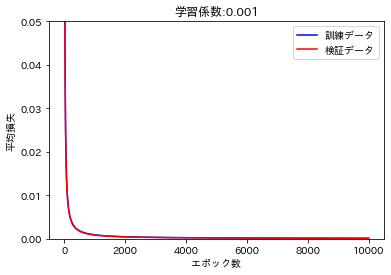

In [14]:
#このセルで定義したロジスティック回帰のテスト
# mnl = MultiNomialLogisticRegression(X_train=Miz_t, y_train=HM)
# mnl.train(max_epochs=12)  #訓練回数を少なくして動作確認
# mnl.plot_loss()        

X_train, y_train, X_val, y_val, train_tags, val_tags = split_dataset(Miz_t, HM)
mnl_ = MultiNomialLogisticRegression(X_train, y_train, X_val, y_val)
mnl_.train(X_train, y_train, X_val, y_val, max_epochs=10 ** 4, lr=1e-02)
mnl_.predict_val(X_val, y_val, target_tags=miz_targets, labels=common_words)
#mnl_.predict_val(X_val, y_val)
mnl_.plot_loss(ylim=0.05)


# 3層パーセプトロンによる水野想起語予測
# Suppose to be a simple logistic regression can predict human free recall words in case of curtain target words given
エポック:    0 訓練損失: 0.250 検証損失: 0.235
エポック:12500 訓練損失: 0.000 検証損失: 0.000
エポック:25000 訓練損失: 0.000 検証損失: 0.000
エポック:37500 訓練損失: 0.000 検証損失: 0.000
エポック:50000 訓練損失: 0.000 検証損失: 0.000


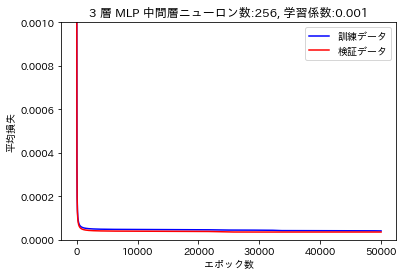

S  0 目標語:頭脳 水野想起1位:携帯電話(0.07) 予測語:かね(0.01)
S  1 目標語:預金 水野想起1位:遊び(0.05) 予測語:夏(0.02)
S  2 目標語:電話 水野想起1位:脳(0.18) 予測語:夏(0.01)
S  3 目標語:電池 水野想起1位:消防車(0.18) 予測語:め(0.01)
S  4 目標語:電気 水野想起1位:はなし(0.22) 予測語:夏(0.02)
S  5 目標語:雇用 水野想起1位:にわとり(0.36) 予測語:夏(0.04)
S  6 目標語:録画 水野想起1位:目印(0.10) 予測語:夏(0.02)
S  7 目標語:野菜 水野想起1位:紙(0.26) 予測語:夏(0.03)
S  8 目標語:都会 水野想起1位:理科(0.17) 予測語:夏(0.01)
S  9 目標語:道路 水野想起1位:連続(0.06) 予測語:夏(0.02)
S 10 目標語:道具 水野想起1位:車(0.25) 予測語:電車(0.04)
S 11 目標語:赤字 水野想起1位:理論(0.06) 予測語:かね(0.02)
S 12 目標語:資源 水野想起1位:花(0.77) 予測語:夏(0.04)
S 13 目標語:資格 水野想起1位:単位(0.09) 予測語:かね(0.02)
S 14 目標語:資本 水野想起1位:充電(0.11) 予測語:かね(0.01)
S 15 目標語:財布 水野想起1位:ホテル(0.33) 予測語:夏(0.02)
S 16 目標語:議論 水野想起1位:ピース(0.14) 予測語:夏(0.01)
S 17 目標語:講義 水野想起1位:過剰(0.13) 予測語:夏(0.01)
S 18 目標語:論理 水野想起1位:芸術(0.15) 予測語:夏(0.01)
S 19 目標語:話題 水野想起1位:年賀状(0.37) 予測語:夏(0.02)
S 20 目標語:試験 水野想起1位:音楽(0.30) 予測語:夏(0.03)
S 21 目標語:記憶 水野想起1位:名前(0.22) 予測語:かね(0.04)
S 22 目標語:言葉 水野想起1位:風邪(0.55) 予測語:夏(0.02)
S 23 目標語:親子 水野想起1位:試験(0.09) 予測語:夏(0.01)
S 24 目標語:視線 水野想起1位:髪(0.20) 予測

In [15]:
np.set_printoptions(suppress=False, formatter={'float': '{:5.2f}'.format})

print('# 3層パーセプトロンによる水野想起語予測')
print('# Suppose to be a simple logistic regression can predict human free recall words \
in case of curtain target words given')
lr = 1e-3

n_hid = 256
LayerH = layer(n_out=n_hid, n_inp=X_train.shape[1], act_f=tanh, lr=lr)
LayerO = layer(n_out=y_train.shape[1], n_inp=n_hid, act_f=sigmoid, lr=lr)

max_epochs = 5 * 10 ** 4
#max_epochs = 10 ** 4
interval = max_epochs >> 2
train_loss, val_loss = [], []
for epoch in range(max_epochs+1):
    H = LayerH.forward(X_train)
    O = LayerO.forward(H)

    #deltaO = O - Tch
    deltaO = O - y_train
    deltaH, dWo = LayerO.backward(deltaO, O, H)
    deltaX, dWh = LayerH.backward(deltaH, H, X_train)
    LayerO.update(dWo)
    LayerH.update(dWh)

    train_loss.append((deltaO ** 2).mean())

    H_val = LayerH.forward(X_val)
    O_val = LayerO.forward(H_val)
    val_delta = O_val - y_val
    val_loss.append((val_delta ** 2).mean() )
        
    if epoch % interval == 0:
        print(f'エポック:{epoch:>5d} 訓練損失: {train_loss[-1]:.3f} 検証損失: {val_loss[-1]:.3f}')
        #print(f'出力:{O.T}')

plt.ylim((0,0.001))
plt.plot(train_loss, color='blue', label='訓練データ')
plt.plot(val_loss, color='red', label='検証データ')
plt.legend()
plt.xlabel('エポック数')
plt.ylabel('平均損失')
plt.title(f'3 層 MLP 中間層ニューロン数:{n_hid}, 学習係数:{lr}')
plt.show()

correct_n = 0
teach = y_val

H = LayerH.forward(X_val)
y_hat = LayerO.forward(H)
deltaO = y_hat - y_val
target_tags = miz_targets
labels = common_words

for i in range(len(y_hat)):
    pred_i = np.argmax(y_hat[i])
    pred_p = y_hat[i][pred_i]
    teach_i = np.argmax(teach[i])
    teach_p = teach[i][teach_i]
    cand_s = np.sort(y_hat[i])[:3]
    teach_s = np.sort(teach[i])[:3]
    if pred_i == teach_i:
        color = 'grey'
        correct_n += 1
    else:
        color = 'red'
                
    print(termcolor.colored(
        'S{0:3d} 目標語:{1} 水野想起1位:{2}({3:.2f}) 予測語:{4}({5:.2f})'.format(
            i, target_tags[i], 
            labels[teach_i], teach_p, 
            labels[pred_i], pred_p), color))

print(f'検証データの正解率: {correct_n/len(y_hat) * 100:.2f} %')


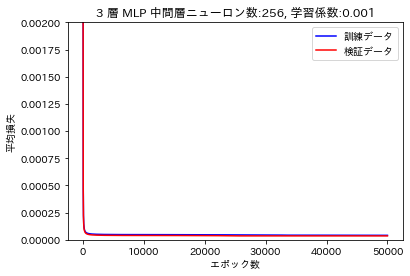

In [16]:
plt.ylim((0,0.002))
plt.plot(train_loss, color='blue', label='訓練データ')
plt.plot(val_loss, color='red', label='検証データ')
plt.legend()
plt.xlabel('エポック数')
plt.ylabel('平均損失')
plt.title(f'3 層 MLP 中間層ニューロン数:{n_hid}, 学習係数:{lr}')
plt.show()

In [21]:
class mlp(object):
    def __init__(self, X_train, y_train, n_hid=128, 
                 act_f = tanh,
                 X_val=None, y_val=None, 
                 lr=1e-3, max_epochs=10 ** 4, interval=None):
        self.n_hid = n_hid
        self.lr = lr
        self.max_epochs = max_epochs
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val if X_val is not None else None
        self.y_val = y_val if y_val is not None else None
        self.interval = interval if interval is not None else self.max_epochs >> 2
        self.LayerH = layer(n_out=n_hid, n_inp=X_train.shape[1], act_f=act_f, lr=lr)
        self.LayerO = layer(n_out=y_train.shape[1], n_inp=n_hid, act_f=sigmoid, lr=lr)

    
    def fit(self, X_train=None, y_train=None, X_val=None, y_val=None,
            lr=1e-03, max_epochs= 10 ** 4, interval=None,
            verbose=True):
        max_epochs = max_epochs if max_epochs is not None else self.max_epochs
        
        interval = interval if interval is not None else max_epochs >> 2
        lr = lr if lr is not None else self.lr
        X = X_train if X_train is not None else self.X_train
        y = y_train if y_train is not None else self.y_train
        
        train_loss, val_loss = [], []

        H = self.LayerH.forward(X_train)
        O = self.LayerO.forward(H)

        #deltaO = O - Tch
        deltaO = O - y_train
        deltaH, dWo = LayerO.backward(deltaO, O, H)
        deltaX, dWh = LayerH.backward(deltaH, H, X_train)
        LayerO.update(dWo)
        LayerH.update(dWh)

        train_loss.append((deltaO ** 2).mean())

        H_val = LayerH.forward(X_val)
        O_val = LayerO.forward(H_val)
        val_delta = O_val - y_val
        val_loss.append((val_delta ** 2).mean() )

        
        if X_val is not None:
            val_O = self.LayerO.forward(X_val)
            val_loss.append(((y_val - val_O)**2).mean())
        if epoch % interval == 0 and verbose:
            print(f'エポック:{epoch:>5d}, 訓練データ損失: {train_loss[-1]:.3f}', end=" ")
            if len(val_loss) > 1:
                print(f' 検証データ損失: {val_loss[-1]:.3f}')
            else:
                print()

        self.train_loss, self.val_loss = train_loss, val_loss
        return train_loss, val_loss

    def train(self, X_train=None, y_train=None, 
              X_val=None, y_val=None,
              lr=1e-03, max_epochs=10 ** 4, verbose=True):
        return  self.fit(X_train=X_train, y_train=y_train,
                         X_val=X_val, y_val=y_val,
                         lr=lr, max_epochs=max_epochs, 
                         verbose=verbose)

        
    def plot_loss(self, ylim=None):
        
        ylim = ylim if ylim is not None else 0.28
        plt.ylim((0, ylim))
        plt.plot(self.train_loss, color='blue', label="訓練データ")
        if self.val_loss is not None:
            plt.plot(self.val_loss, color='red', label='検証データ')
        plt.xlabel('エポック数')
        plt.ylabel('平均損失')
        plt.title(f'学習係数:{self.lr}')
        plt.legend()
        plt.show()
        
        
    def predict(self, X):
        O = self.LayerO.forward(X)
        return O
    
    def predict_val(self, X_val, y_val, target_tags=None, labels=None):
        
        labels = labels if labels is not None else np.arange(y_val.shape[1])
        target_tags = target_tags if target_tags is not None else np.arange(X_val.shape[0])
        
        y_hat = self.LayerO.forward(X_val)
        teach = y_val
            
        correct_n = 0
        for i in range(len(y_hat)):
            pred_i = np.argmax(y_hat[i])
            pred_p = y_hat[i][pred_i]
            teach_i = np.argmax(teach[i])
            teach_p = teach[i][teach_i]
            cand_s = np.sort(y_hat[i])[:3]
            teach_s = np.sort(teach[i])[:3]
            if pred_i == teach_i:
                color = 'grey'
                correct_n += 1
            else:
                color = 'red'
                
            print(termcolor.colored(
                'S{0:3d} 目標語:{1} 水野想起1位:{2}({3:.2f}) 予測語:{4}({5:.2f})'.format(
                i, target_tags[i], 
                labels[teach_i], teach_p, 
                labels[pred_i], pred_p), color))

        print(f'検証データの正解率: {correct_n/len(y_hat) * 100:.2f} %')
        

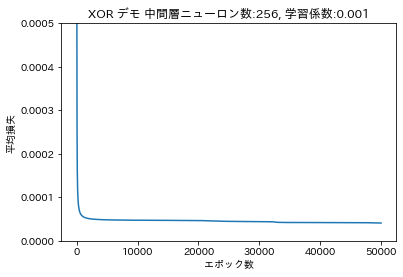

In [22]:
plt.ylim((0,0.0005))
plt.plot(train_loss)
plt.xlabel('エポック数')
plt.ylabel('平均損失')
plt.title(f'XOR デモ 中間層ニューロン数:{n_hid}, 学習係数:{lr}')
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
import tsne

pca_result = tsne.pca(Miz_t)
tsne_result = tsne.tsne(Miz_t)

import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10,10))
plt.scatter(pca_result[:,0], pca_result[:,1], color='cyan')
for i, l in enumerate(miz_targets):
     plt.annotate(l, (pca_result[i,0], pca_result[i,1]), fontsize=10)
plt.show()

plt.figure(figsize=(12,12))
plt.scatter(tsne_result[:,0], tsne_result[:,1], color='cyan')
for i, l in enumerate(miz_targets):
     plt.annotate(l, (tsne_result[i,0], tsne_result[i,1]), fontsize=12)
plt.show()

In [ ]:
M_w = np.zeros((len(miz_targets), topn, w2v['日本語'].shape[0]), dtype=np.float32)

for target in miz_targets:
    target_id = miz_targets.index(target)

    #機械の類似語を上位 topn 語を取得
    sim_words = [x[0] for x in w2v.most_similar(target, topn=topn)]
    for i, sim_word in enumerate(sim_words):
        sim_word_id = machine_topn_sim_words.index(sim_word)
        M_w[target_id][i] = np.copy(w2v[sim_word])

print(f'機械連想語 上位 (topn):{topn} 語の総語彙数:{len(machine_topn_sim_words)}')
print(f'M_w.shape: {M_w.shape}')

In [ ]:
print(f'機械の水野連想語上位 {topn} 語 総類似語数:{len(machine_topn_sim_words)}')
print(f'上の単語例 ランダムサンプリング:{np.random.choice(machine_topn_sim_words, size=8)}')

print('#machine_topn_sim_words の word2vec ベクトル行列を Machien_rv とする')
Machine_rv = np.zeros((len(machine_topn_sim_words), w2v['日本語'].shape[0]), dtype=np.float32)
for sim_word in machine_topn_sim_words:
    sim_word_id = machine_topn_sim_words.index(sim_word)
    Machine_rv[sim_word_id] = np.copy(w2v[sim_word])
print(f'Machine_rv.shape:{Machine_rv.shape}')

In [ ]:
print(f'水野全応答語数:{len(all_resp_words)}, topn={topn} とした場合の w2v 総単語数:{len(machine_topn_sim_words)}, それらの和:{len(all_resp_words)+len(machine_topn_sim_words)}')

human_words = sorted(set(all_resp_words))[::-1]
machine_words = machine_topn_sim_words
HumMac_Rwords = sorted(set(all_resp_words) | set(machine_topn_sim_words))[::-1]
print(f'人間と機械の想起語 HumMac_Rwords 単語数: {len(HumMac_Rwords)}')
grand_HumMac_Rwords = sorted(set(HumMac_Rwords) | set(miz_targets))[::-1]
print(f'HumMac_Rwords とターゲット語の和集合 grand_all_words:{len(grand_HumMac_Rwords)}')
print(f'その積集合:{len(set(all_resp_words) & set(all_sim_words) & set(miz_targets))}')
print(sorted(list(set(all_resp_words) & set(all_sim_words) & set(miz_targets)))[::-1])

一番簡単なのは，水野ターゲット (296) 語の word2vec (200次元)から all_resp_words(7848) の連想強度 を予測させることだ。
X = (296, 200), y = (7848,1) ということをしてみる

In [ ]:
#y = tsne.tsne(X)
for target in miz_targets[:3]:
    target_id = miz
    print([res_word_list[i] for i in np.argsort(Euc[0][1:])])
print([x for x in list(Miz_SRdict['赤字'])])

In [ ]:
print(len(model.coefs_[0]), len(model.coefs_[1]))
print(len(model.intercepts_[0]), len(model.intercepts_[1]))
print(model.n_iter_)
print(model.out_activation_)
print(model.get_params)

In [ ]:
#ヒストグラムの描画
import matplotlib.pyplot as plt
import japanize_matplotlib
import math

def draw_hist(D, Excel, From=0, To=None, fraw_fig=True, inches=(20, 16), fname=None):
    From = 0 if From == None else From
    To = len(D) if To == None else To
    N = To - From
    n_col = 5
    fig, axs = plt.subplots(math.ceil(N/n_col), n_col, figsize=inches)
    ai, aj = 0, 0
    
    for target in list(D)[From:To]:
        axs[ai][aj].set_ylim(0,95)
        axs[ai][aj].set_xlim(-0.01,0.95)
        x = [(x[1]['連想強度']) for x in list(Excel.parse(sheet_name=target)[['連想強度']].iterrows())]
        axs[ai][aj].set_title(f'ターゲット語:{target}')
        axs[ai][aj].hist(x, bins=10)
        
        aj += 1
        if aj % n_col == 0:
            ai+=1; aj=0
            
    if fname != None:
        plt.savefig(fname)
    else:
        plt.show()

#draw_hist(Hira, hiragana, From=00, To=20)
# draw_hist(Kanji, kanji, From=00, To=20, fname='Mizu_hist_kanji00-20.pdf')

for data, excel in zip(['Kanji', 'Kata', 'Hira'], [kanji, katakana, hiragana]):
    for x in range(0,100,20):
        From = x
        To = x + 20
        fname ='Mizu_hist_{0:}{1:02d}-{2:02d}.pdf'.format(data,x,x+20)
        draw_hist(eval(data), excel, From=From, To=To, fname=fname)
        
# draw_hist(Kanji, From=20, To=40, fname='2021_0526Mizuno_kanji20-40.pdf')
# draw_hist(Kanji, From=40, To=60, fname='2021_0526Mizuno_kanji40-60.pdf')
# draw_hist(Kanji, From=60, To=80, fname='2021_0526Mizuno_kanji60-80.pdf')
# draw_hist(Kanji, From=80, To=None, fname='2021_0526Mizuno_kanji80-100.pdf')

In [ ]:
for target in list(Miz_SRdict):
    A = np.array([Miz_SRdict[target][resp] for resp in list(Miz_SRdict[target])])
    print(w1, A.shape, end=", ")

In [ ]:
from numpy.polynomial.polynomial import polyfit
import math

print('# 水野連想強度と word2vec のコサイン類似度との相関係数を計算')

D = Kanji
Excel = kanji
draw_flag = True
cut_off = 0.02

#def draw_scatt(N=2, D=Kanji, Excel=kanji, save_figname=None, draw_fig=True, cutoff=0.02, figsize=(5,4), fontsize=14):
def draw_scatt(From=0, To=100, D=Kanji, Excel=kanji, save_figname=None, draw_fig=True, cutoff=0.02, figsize=(5,4), fontsize=12):

    N = To - From
    inches = (20, ((N // 5) * 5))
    print(f'inches={inches}')
    #sys.exit()

#     if N == 0:
#         N = len(list(D))
              
    if draw_fig:
        #fig, axs = plt.subplots(math.ceil(N/5), 5, figsize=(20,85))
        fig, axs = plt.subplots(math.ceil(N/5), 5, figsize=inches)
        ai, aj = 0, 0
    
    for target in list(D)[From:To]:
        if not target in w2v:
            continue
        df = Excel.parse(sheet_name=target)
        words = list(df[target])[:-1]
        mizuno_vals = np.array(list(df['連想強度'])[:-1])
        mizuno_words = []
        machines, humans = [], []
        for i, word in enumerate(words):
            v = mizuno_vals[i]
            if (word in w2v) and (v > cutoff):
                mizuno_words.append(word)
                machines.append(w2v.similarity(target, word))
                humans.append(mizuno_vals[i])
        humans, machines = np.array(humans), np.array(machines)
        R = np.corrcoef(humans, machines)[0,1]
        if not draw_fig:
            print(f'刺激語:{target} R={R:.3} カットオフ値:{cutoff}')
    
        if draw_flag or (save_figname is not None):
            y_min, y_max = machines.min(), machines.max()
            x_min, x_max = humans.min(), humans.max()
            
            #plt.figure(figsize=figsize)
            axs[ai][aj].set_xlabel('水野連想強度')
            axs[ai][aj].set_ylabel('word2vec コサイン類似度')
            axs[ai][aj].set_title("刺激語:{0} R={1:.3}, cutoff={2:.2f}".format(target,R,cutoff))
            axs[ai][aj].set_ylim(y_min-0.01,y_max+0.01)
            axs[ai][aj].set_xlim(x_min-0.01,x_max+0.01)
            axs[ai][aj].scatter(humans, machines)
            for i, label in enumerate(mizuno_words):
                axs[ai][aj].annotate(label, (humans[i], machines[i]),fontsize=fontsize)
            
            # Fit with polyfit
            bias, slope = polyfit(humans, machines, 1)
            #plt.plot(x, y, '.')
            axs[ai][aj].plot(humans, bias + slope * humans, '-', color='pink')
            
            aj += 1
            if aj % 5 == 0:
                ai+=1; aj=0
 
    if (save_figname is not None) and draw_fig:
        plt.savefig(save_figname)
    if draw_fig:
        plt.show()

draw_scatt(From=0, To=25, D=Kanji, Excel=kanji, save_figname='figs/2021_0512Mizuno_kanji_scat000_025.pdf')
draw_scatt(From=25, To=50, D=Kanji, Excel=kanji, save_figname='figs/2021_0512Mizuno_kanji_scat025_050.pdf')
draw_scatt(From=50, To=75, D=Kanji, Excel=kanji, save_figname='figs/2021_0512Mizuno_kanji_scat050_075.pdf')
draw_scatt(From=75, To=100, D=Kanji, Excel=kanji, save_figname='figs/2021_0512Mizuno_kanji_scat075_100.pdf')
draw_scatt(From=0, To=25, D=Kata, Excel=katakana, save_figname='figs/2021_0512Mizuno_katakana_scat000_025.pdf')
draw_scatt(From=25, To=50, D=Kata, Excel=katakana, save_figname='figs/2021_0512Mizuno_katakana_scat025_050.pdf')
draw_scatt(From=50, To=75, D=Kata, Excel=katakana, save_figname='figs/2021_0512Mizuno_katakana_scat050_075.pdf')
draw_scatt(From=75, To=100, D=Kata, Excel=katakana, save_figname='figs/2021_0512Mizuno_katakana_scat075_100.pdf')
draw_scatt(From=0, To=25, D=Hira, Excel=hiragana, save_figname='figs/2021_0512Mizuno_hiragana_scat000_025.pdf')
draw_scatt(From=25, To=50, D=Hira, Excel=hiragana, save_figname='figs/2021_0512Mizuno_hiragana_scat025_050.pdf')
draw_scatt(From=50, To=75, D=Hira, Excel=hiragana, save_figname='figs/2021_0512Mizuno_hiragana_scat050_075.pdf')
draw_scatt(From=75, To=100, D=Hira, Excel=hiragana, save_figname='figs/2021_0512Mizuno_hiragana_scat075_100.pdf')

# 以下は古い関数
# draw_scatt(D=Kanji, Excel=kanji, N=0,   save_figname='2021_0512Mizuno_kanji_scat.pdf')
# draw_scatt(D=Kata, Excel=katakana, N=0, save_figname='2021_0512Mizuno_katakana_scat.pdf')
# draw_scatt(D=Hira, Excel=hiragana, N=0, save_figname='2021_0512Mizuno_hikagana_scat.pdf')

In [ ]:
def mizuno_R(Orth_type, w2v=w2v):
    R = {}  #水野リストと w2v との単純な相関係数
    w2v_list = list(w2v.vocab)
    for i, target in enumerate(list(Orth_type)):
        if not target in w2v:
            continue
        mizu = [w2v_list.index(w) for w in Orth_type[target] if w in w2v_list]
        mizuw = [w for w in Orth_type[target] if w in w2v_list]
        w2v_ = [w2v_list.index(x[0]) for x in w2v.most_similar(target, topn=len(mizu))]
        w2v_w = [x[0] for x in w2v.most_similar(target, topn=len(mizu))]
        r, p = stats.spearmanr(mizu, w2v_)
        color = 'red' if p < 0.05 else 'grey'
        print(termcolor.colored(f'{i:<3d} ターゲット:{target} word2vecとの相関係数:{r:+.3f} prob.:{p:.3f}*, N:{len(mizuw)}', 
                                color), end='            \r')
        R[target] = {'r':r, 'prob':p, '水野リスト順':mizuw, 'w2v_most_similar':w2v_w}
        
    tag_r_and_p = [[x, R[x]['r'], R[x]['prob']] for x in list(R)]
    r_and_p = [aa_[1] for aa_ in tag_r_and_p]
    ord_list = np.argsort(r_and_p)[::-1]
    #print([list(R)[x] for x in ord_list])
    #print(ord_list)
    print()
    print(f'最大相関係数: {ord_list[0]:2d}:{list(R)[ord_list[0]]}(r={r_and_p[ord_list[0]]:.3f}) ')
    print(f'最低相関係数: {ord_list[-1]:2d}:{list(R)[ord_list[-1]]}(r={r_and_p[ord_list[-1]]:.3f}) ')
    print(f'相関係数の高い順 {["{1:2d}:{0}({2:.3f})".format(list(R)[x], x, r_and_p[x]) for x in ord_list]}')

    return R


def mizuno_R2(Orth_type, w2v=w2v):
    R = {}  #水野リスト内の単語だけを使って
    w2v_list = list(w2v.vocab)
    for i, target in enumerate(list(Orth_type)):
        if not target in w2v:
            continue
        w_list, w_val = [], []
        for w in Orth_type[target]:
            if w in w2v_list:
                w_list.append(w)
                w_val.append(w2v.similarity(target, w))
            
        w2v_order = [w_list[x] for x in np.argsort(w_val)[::-1]]
        r, p = stats.spearmanr(np.arange(len(w_list)), np.argsort(w_val)[::-1])
        color = 'red' if p < 0.05 else 'grey'
        print(termcolor.colored(f'{i:<3d} ターゲット:{target}, ', color=color), end="")
        print(termcolor.colored(f'word2vec との相関係数:{r:.3f}, ',color=color), end="")
        print(termcolor.colored(f'prob.:{p:.3f}*, N:{len(w_list)}',color=color), end="       \r") 
        R[target] = {'r':r, 'prob':p, '水野リスト順':w_list, 'wor2vec順':w2v_order}

    tag_r_and_p = [[x, R[x]['r'], R[x]['prob']] for x in list(R)]
    r_and_p = [aa_[1] for aa_ in tag_r_and_p]
    ord_list = np.argsort(r_and_p)[::-1]
    print()
    print(f'最大相関係数: {ord_list[0]:2d}:{list(R)[ord_list[0]]}(r={r_and_p[ord_list[0]]:.3f}) ')
    print(f'最低相関係数: {ord_list[-1]:2d}:{list(R)[ord_list[-1]]}(r={r_and_p[ord_list[-1]]:.3f}) ')
    print(f'相関係数の高い順 {["{1:2d}:{0}({2:.3f})".format(list(R)[x], x, r_and_p[x]) for x in ord_list]}')
    return R

R1 = mizuno_R(Kanji)
R2 = mizuno_R2(Kanji)
R3 = mizuno_R(Kata)
R4 = mizuno_R2(Kata)
R5 = mizuno_R(Hira)
R6 = mizuno_R2(Hira)

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

def draw_R(R,title="", width=24, height=8, filename=False):
    item_and_r_list = [[x, R[x]['r']] for x in R]
    r_orders = np.argsort(np.array([item_and_r[1] for item_and_r in item_and_r_list]))# [::-1]
    r_vals = np.array([item_and_r[1] for item_and_r in item_and_r_list])
    r_names = [item_and_r[0] for item_and_r in item_and_r_list] # [::-1]
    plt.figure(figsize=(width,height))
    #plt.xlabel(r_names)
    print(f'r_orders: {r_orders[::-1]}')
    print([r_names[r_orders[i]] for i in range(len(r_names))])
    #print(f'r_names: {r_names}')
    x = [r_vals[no] for no in r_orders]
    #plt.bar(range(len(r_vals)), x, color='pink')
    plt.barh(range(len(r_vals)), x, color='pink')
    plt.title(title)
    y_pos = range(len(r_names))
    #plt.xticks(y_pos, r_names, rotation=90)
    plt.yticks(y_pos, [r_names[r_orders[i]] for i in range(len(r_names))])
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

    
width, height = 18, 26
draw_R(R2, title="漢字単語 人間(水野ら,2011) と word2vec との相関係数", width=width, height=height, filename='2011Mizuno_Kanji_R2.pdf')
draw_R(R4, title="カタカナ単語 人間(水野ら,2011) と word2vec との相関係数", width=width, height=height, filename='2011Mizuno_Kata_R2.pdf')
draw_R(R6, title='ひらがな単語 人間(水野ら,2011) と word2vec との相関係数', width=width, height=height, filename='2011Mizuno_Hira_R2.pdf')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

def draw_scat_gram(R, w2v=w2v, width=13, height=14, fontsize=12, filename=None):
    pca = PCA(n_components=2)
    dim1 = len(list(R))
    dim2 = w2v['赤字'].shape[0]
    X = np.zeros((dim1, dim2))
    for i, wi in enumerate(list(R)):
        X[i] = np.copy(w2v[wi])
    labels = list(R)

    pca_results = pca.fit_transform(X)
    pca1, pca2 = pca_results[:,0], pca_results[:,1] 
    fig, ax = plt.subplots(figsize=(width, height))  
    ax.scatter(pca1, pca2, s=20, color='cyan')
    for i, l in enumerate(labels):
         ax.annotate(l, (pca1[i], pca2[i]), fontsize=fontsize)
    ax.set_xlabel('第一主成分')
    ax.set_ylabel('第二主成分')
    if filename != None:
        plt.savefig(filename+'_pca.pdf')

    tsne_results = TSNE(n_components=2).fit_transform(X)
    tsne1, tsne2 = tsne_results[:,0], tsne_results[:,1]
    fig, ax = plt.subplots(figsize=(width, height))
    ax.scatter(tsne1, tsne2, s=20, color='cyan')
    for i, l in enumerate(labels):
        ax.annotate(l, (tsne1[i], tsne2[i]),fontsize=fontsize)
    ax.set_xlabel('tSNE 1')
    ax.set_ylabel('tSNE 2')
    if filename != None:
        plt.savefig(filename+'_tSNE.pdf')

draw_scat_gram(R6, width=10, height=11, filename='2011Mizuno_R6plot')
